# 1. Set WRKDIR for dataset

Google drive would ask for access.

In [1]:
"""
from google.colab import drive
drive.mount('/content/drive')

!unzip -qo "/content/drive/MyDrive/metro_data/dataset_v5_ts_npz.zip" -d .
WRKDIR = '/content/dataset_v5_ts_npz/'
"""
WRKDIR = './DATA/dataset_v5_ts_npz/'

# 2. installs, imports, fix seed

In [2]:
import re
from glob import glob
from pathlib import Path

import torch
import random
import bisect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import StratifiedKFold

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device!")

Using cpu device!


/home/palko/projects/soh-ml/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
#from lightning import seed_everything

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)
#seed_everything(42)

In [5]:
def make_batteries_info():
    batteries_paths = glob(WRKDIR + '/**/*/')
    IDs = [Path(s).stem for s in batteries_paths]
    df = pd.DataFrame({'ID':IDs, 'battery_path': batteries_paths})
    df['large_small'] = df.ID.apply(lambda s: re.sub(r'_.*$', '', s))
    df['chem'] = df.ID.apply(lambda s: re.sub(r'^.*_([A-Za-z]+)\d+$', r'\1', s))

    info_csv = pd.read_csv(WRKDIR + 'info.csv').rename(columns = {'Unnamed: 0': 'ID_without_size'})
    info_csv['ID'] = info_csv['large'].apply(lambda s: 'large' if s else 'small') + '_' + info_csv['ID_without_size']
    info_csv[['ID', 'n_cycles']]
    df_merged = pd.merge(df, info_csv[['ID', 'n_cycles']], on = 'ID', how = 'inner')

    return df_merged

info = make_batteries_info()
info

,ID,battery_path,large_small,chem,n_cycles
0,small_NMC15,./DATA/dataset_v5_ts_npz/NMC/small_NMC15/,small,NMC,5
1,small_NMC14,./DATA/dataset_v5_ts_npz/NMC/small_NMC14/,small,NMC,5
2,large_NMC7,./DATA/dataset_v5_ts_npz/NMC/large_NMC7/,large,NMC,897
3,small_NMC10,./DATA/dataset_v5_ts_npz/NMC/small_NMC10/,small,NMC,5
4,large_NMC13,./DATA/dataset_v5_ts_npz/NMC/large_NMC13/,large,NMC,769
5,large_NMC12,./DATA/dataset_v5_ts_npz/NMC/large_NMC12/,large,NMC,970
6,large_NMC6,./DATA/dataset_v5_ts_npz/NMC/large_NMC6/,large,NMC,893
7,small_NMC11,./DATA/dataset_v5_ts_npz/NMC/small_NMC11/,small,NMC,6
8,small_LTO5,./DATA/dataset_v5_ts_npz/LTO/small_LTO5/,small,LTO,6
9,large_LTO12,./DATA/dataset_v5_ts_npz/LTO/large_LTO12/,large,LTO,877


# 3. Functionality for visualization, splitting
distribution of normalizied capacities  \
of each battery in a group (groupBatteriesHist)  \
(note that it required DataClass)
  \

and of the whole group (bagOfCapacitiesHist)  \

strat K fold

## 3.1 Visualization of target distribution

In [6]:
# ------------------------------------
# Visualization of target distribution
# ------------------------------------

def singleBatteryHist(
        ID,
        path,
        ax,
        DataClass,
        figsize = (6, 8),
        hist_options = {
                    'bins': 'auto',
                    'alpha': 0.7,
                    'color': 'green',
                    'edgecolor': 'black',
                    'label': ' ',
                },
    ):
        targets = DataClass(path).data['norm_cap'].values

        ax.set_title(ID)
        ax.hist(
                targets,
                **hist_options,
            )
        ax.legend(title = ID)
        ax.set_xlim(0.5, 1.1)
        ax.set_xlabel('soh')

def groupBatteriesHist(info, DataClass):
    #info_iterrows = info.iterrows()

    nrows = len(info) // 4 + (len(info) % 4 > 0)
    ncols = len(info) // nrows + (len(info) % nrows > 0)

    fig, axes = plt.subplots(
            nrows = nrows,
            ncols = ncols,
            figsize = (ncols*3, nrows*2),
        )
    fig.subplots_adjust(hspace = 0.8)

    axes_flat = axes.flatten()
    #for ax in axes.flatten():
    for k, (i, row) in enumerate(info.iterrows()):
        #i, row = next(info_iterrows)
        singleBatteryHist(
                ID = row['ID'],
                path = row['battery_path'],
                ax = axes_flat[k],
                DataClass = DataClass,
            )
    plt.show()

def bagOfCapacitiesHist(
            info,
            DataClass,
            title = ' ',
            ax = None,
            hist_options = {
                    'bins': 'auto',
                    'alpha': 0.7,
                    'color': 'green',
                    'edgecolor': 'black',
                },
        ):

    all_targets = [DataClass(row['battery_path']).data['norm_cap'].to_numpy() for i, row in info.iterrows()]
    all_targets = np.concatenate(all_targets)

    if ax is None:
        plt.figure()
        plt.title(title)
        plt.hist(
                all_targets,
                **hist_options,
                label = ' ',
            )

        plt.xlim(0.5, 1.1)
        plt.xlabel('soh')
        plt.show()

    else:
        ax.set_title(title)
        ax.hist(
                all_targets,
                **hist_options,
            )

        ax.set_xlim(0.501, 1.099)
        ax.set_xlabel('soh')

## 3.2 Stratified K-fold

In [7]:
# -----------------
# Stratified K-fold
# -----------------

def strat_k_fold(
            df,
            n_splits = 1,
            verbose = False,
            plot = False,
            strat_label = 'chem',
        ):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    X = df.index.to_list()  # индексы датафрейма (можно заменить на df[['ID']])
    y = df[strat_label].to_list()       # метки для стратификации

    if plot:
        fig, axes = plt.subplots(
                nrows = n_splits,
                ncols = 2,
                figsize = (6.4, 4.8*n_splits/2),
                sharex = True,
                sharey = True,
            )
        fig.subplots_adjust(hspace = 0, wspace = 0)

    folds_output = []
    # Генерация фолдов
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]
        folds_output.append({'train':train_df['ID'].tolist(), 'val': val_df['ID'].tolist()})

        if verbose:
            print(f"Fold {fold}:")
            print("Train IDs:", train_df['ID'].tolist())
            print("Val IDs:", val_df['ID'].tolist())
            print("\n")

        if plot:
            bagOfCapacitiesHist(train_df, ax = axes[fold-1, 0])
            bagOfCapacitiesHist(val_df, ax = axes[fold-1, 1])
            axes[fold-1,0].legend(title = f'fold {fold}, train', loc = 'upper left')
            axes[fold-1,1].legend(title = f'fold {fold}, val', loc = 'upper left')

    if plot:
        plt.show()

    return folds_output

# 4. DataSets Classes

single battery dataset  \
composite battery dataset (includes 1 or more single battery datasets)  \
function for creation of composite dataset

## 4.1 Single Battery Dataset

In [8]:
# ----------------------
# Single Battery Dataset
# ----------------------

class SingleBatteryDataset(Dataset):
    """Represents all timeseries and corresponding targets of one battery

    ```
    Attributes
    ----------
    battery_path : str
        path to folder where all data for specified battery is stored

    features_step : int, default 1
        slicing step for extraction of features.

    features_npz_key : str, default 'current_voltage_unitless'
        key for acessing time series when reading .npz file

    normalize_features : callable, default None
        normalization transformation of features, by default keeps features
        timeseries unchanged

    normalize_targets : callable, default None
        normalization transformation of target, by default keeps target(s)
        unchanged

    n_diff : int or None, default None
        if not None, is used to make differencing:
        np.diff(features, axis = 0, n = n_diff)

    data : DataFrame
        stores info about cycle_numbers, paths and norm_cap (target) value

    Methods
    -------
    _prepare_data():
        used for construction of dataframe which stored in data attribute

    __getitem__(idx):
        returns features and target for the data.iloc[idx]
    """
    def __init__(
                self,
                battery_path: str,
                x_step : int = 1,
                x_npz_key : str = 'current_voltage_unitless',
                normalize : dict[callable] = {},
                n_diff : int or None = None,
            ):
        super().__init__()
        self.battery_path = battery_path
        self.x_step = x_step
        self.x_npz_key = x_npz_key

        self.normalize = {'x': None, 'y': None}
        self.normalize.update(normalize)

        self.n_diff = n_diff

        self.data = self._prepare_data()

    def _prepare_data(self):
        # Get time series paths
        ts_paths = glob(self.battery_path + '/time_series/*.npz')
        cycle_numbers = [int(re.findall(r'_(\d+)\.npz', p)[0]) for p in ts_paths]
        ts_df = pd.DataFrame({
            'cycle': cycle_numbers,
            'path': ts_paths
        }).sort_values('cycle')

        # Get targets
        targets_path = glob(self.battery_path + '/*targets.csv')[0]
        targets_df = pd.read_csv(targets_path).sort_values('number_cycle')

        # Merge and validate
        merged = pd.merge(
            targets_df,
            ts_df,
            left_on='number_cycle',
            right_on='cycle'
        ).drop(columns='cycle')

        assert len(merged) == len(ts_df), "Mismatch between cycles and targets"
        return merged

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load time series data
        row = self.data.iloc[idx]
        x = np.load(row['path'])[self.x_npz_key][::self.x_step]
        if self.n_diff is not None:
            x = np.diff(x, axis = 0, n = self.n_diff)

        # Convert to tensors, normalize
        x = torch.tensor(x)  # [seq_len, 2]
        if self.normalize['x'] is not None:
            x = self.normalize['x'](x)

        # 'norm_cap' means that capacity is normalized to capacity at zero cycle,
        # but 'norm_cap' is not scaled by mean and std of dataset
        y = torch.tensor(row['norm_cap'], dtype=torch.float32)  # scalar
        if self.normalize['y'] is not None:
            y = self.normalize['y'](y)

        return {
            'x': x,
            'y': y,
        }

# 6. Splitting Data

## 6.1 Distribution of target values in all batteries

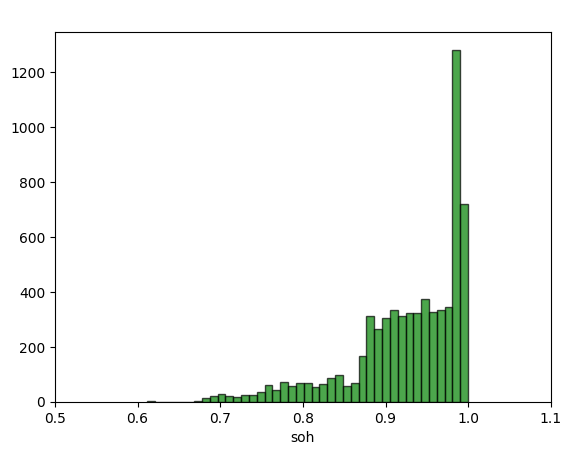

In [9]:
# ----------------------------------------------
# distribution of target values in all batteries
# ----------------------------------------------

bagOfCapacitiesHist(info, SingleBatteryDataset)

## 6.2 Distribution of target values in each battery

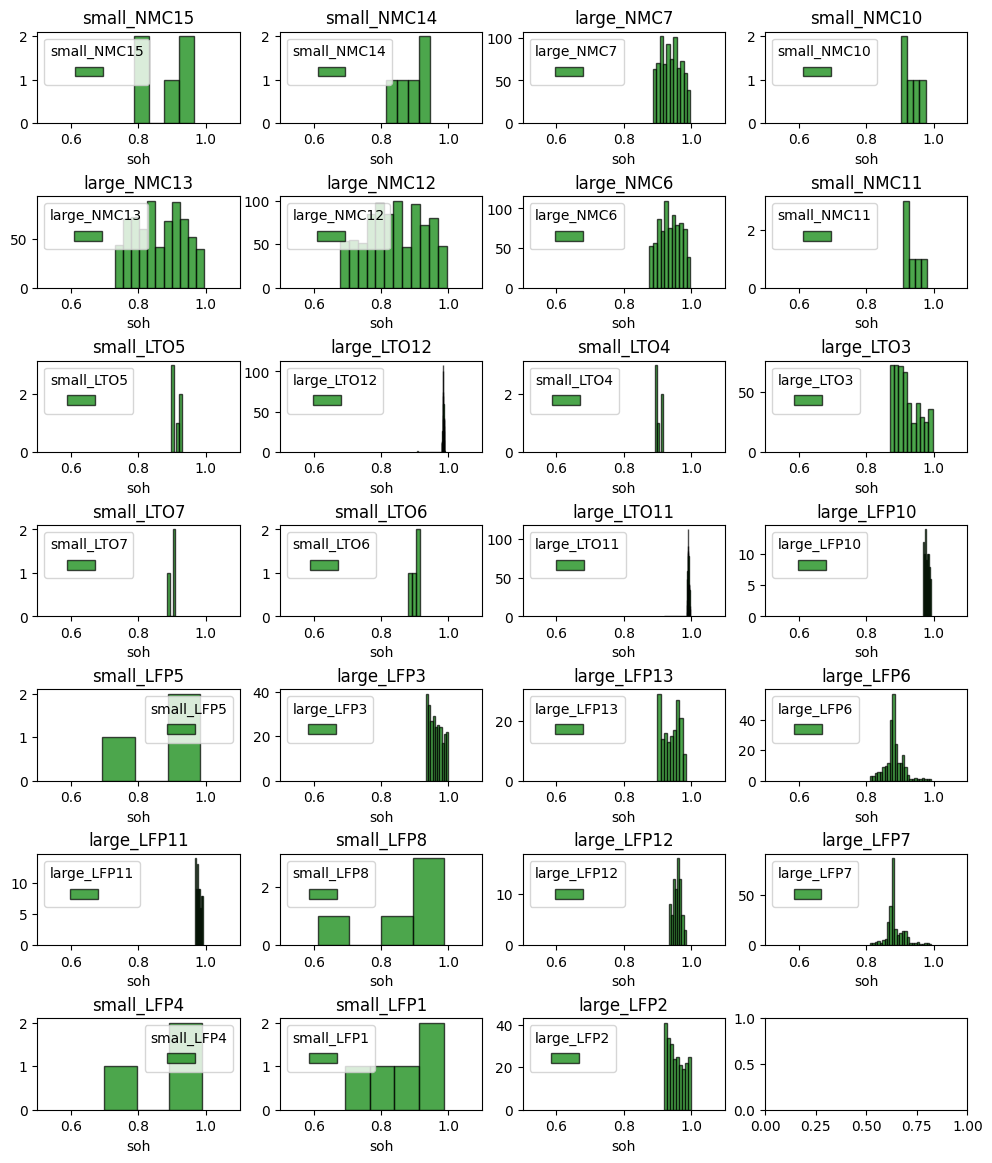

In [10]:
# ----------------------------------------------
# distribution of target values for each battery
# ----------------------------------------------

groupBatteriesHist(info, SingleBatteryDataset)

## 6.3 Blacklist of batteries

There can be seen few batteries with too narrow distribution of target values.  \
They are:

*   large_LTO12
*   large_LTO11
*   large_LFP11
*   large_LFP10
*   small_LTO7
*   small_LTO6
*   small_LTO4
*   small_LTO5



In [11]:
blacklist = [
        'large_LFP10',
        'large_LFP11',
        'large_LTO11',
        'large_LTO12',
        'small_LTO7',
        'small_LTO6',
        'small_LTO4',
        'small_LTO5',
    ]
blacklist_info = info.query('ID in @blacklist')
whitelist_info = info.query('ID not in @blacklist')

lets look at them:

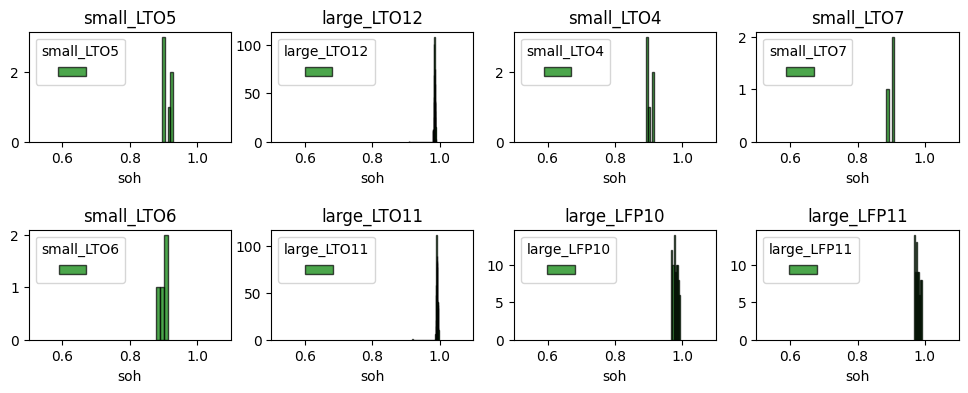

In [12]:
groupBatteriesHist(blacklist_info, SingleBatteryDataset)

lets look how distribution changes when blacklist batteries are excluded: \
(here the scale of y-axis (counts) is the same for both graphs)

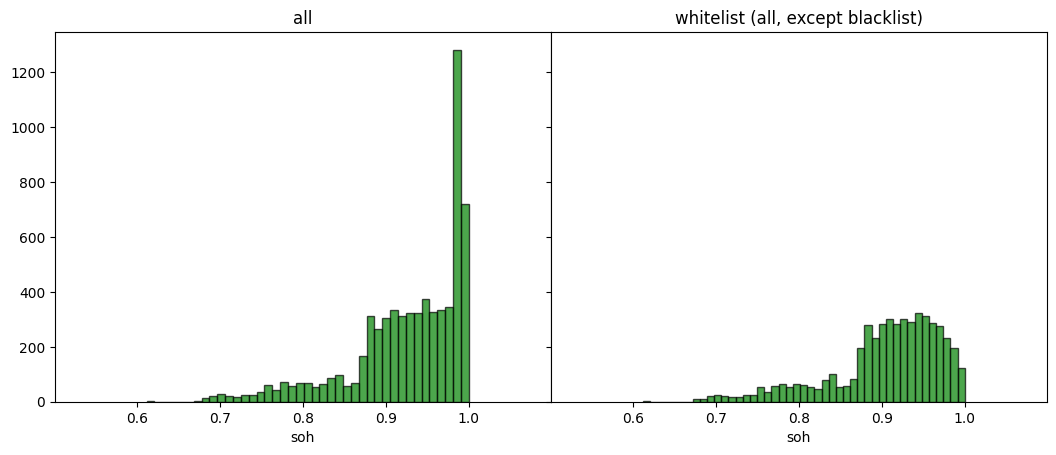

In [13]:
fig, axes = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (6.4*2, 4.8),
    sharex = True,
    sharey = True,
)
fig.subplots_adjust(wspace = 0)

bagOfCapacitiesHist(
    info,
    SingleBatteryDataset,
    title = 'all',
    ax = axes[0],
)
bagOfCapacitiesHist(
    whitelist_info,
    SingleBatteryDataset,
    title = 'whitelist (all, except blacklist)',
    ax = axes[1],
)

plt.show()

## 6.4 Decisionmaking on splitting

### 6.4.1 Whitelist

lets get look on each of remaining batteries and their target distriubutions:

In [14]:
whitelist_info

,ID,battery_path,large_small,chem,n_cycles
0,small_NMC15,./DATA/dataset_v5_ts_npz/NMC/small_NMC15/,small,NMC,5
1,small_NMC14,./DATA/dataset_v5_ts_npz/NMC/small_NMC14/,small,NMC,5
2,large_NMC7,./DATA/dataset_v5_ts_npz/NMC/large_NMC7/,large,NMC,897
3,small_NMC10,./DATA/dataset_v5_ts_npz/NMC/small_NMC10/,small,NMC,5
4,large_NMC13,./DATA/dataset_v5_ts_npz/NMC/large_NMC13/,large,NMC,769
5,large_NMC12,./DATA/dataset_v5_ts_npz/NMC/large_NMC12/,large,NMC,970
6,large_NMC6,./DATA/dataset_v5_ts_npz/NMC/large_NMC6/,large,NMC,893
7,small_NMC11,./DATA/dataset_v5_ts_npz/NMC/small_NMC11/,small,NMC,6
11,large_LTO3,./DATA/dataset_v5_ts_npz/LTO/large_LTO3/,large,LTO,535
16,small_LFP5,./DATA/dataset_v5_ts_npz/LFP/small_LFP5/,small,LFP,3


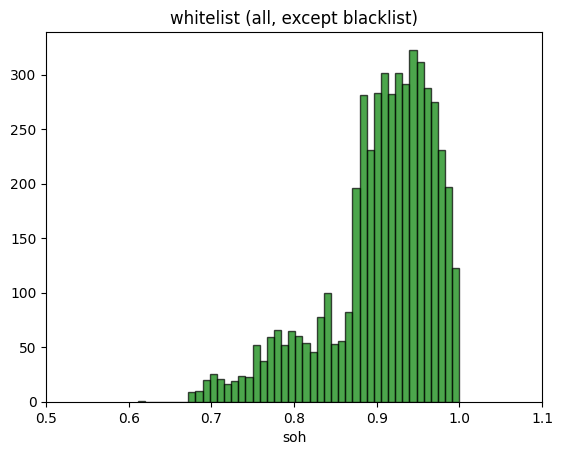

In [15]:
bagOfCapacitiesHist(whitelist_info, SingleBatteryDataset, title = 'whitelist (all, except blacklist)')

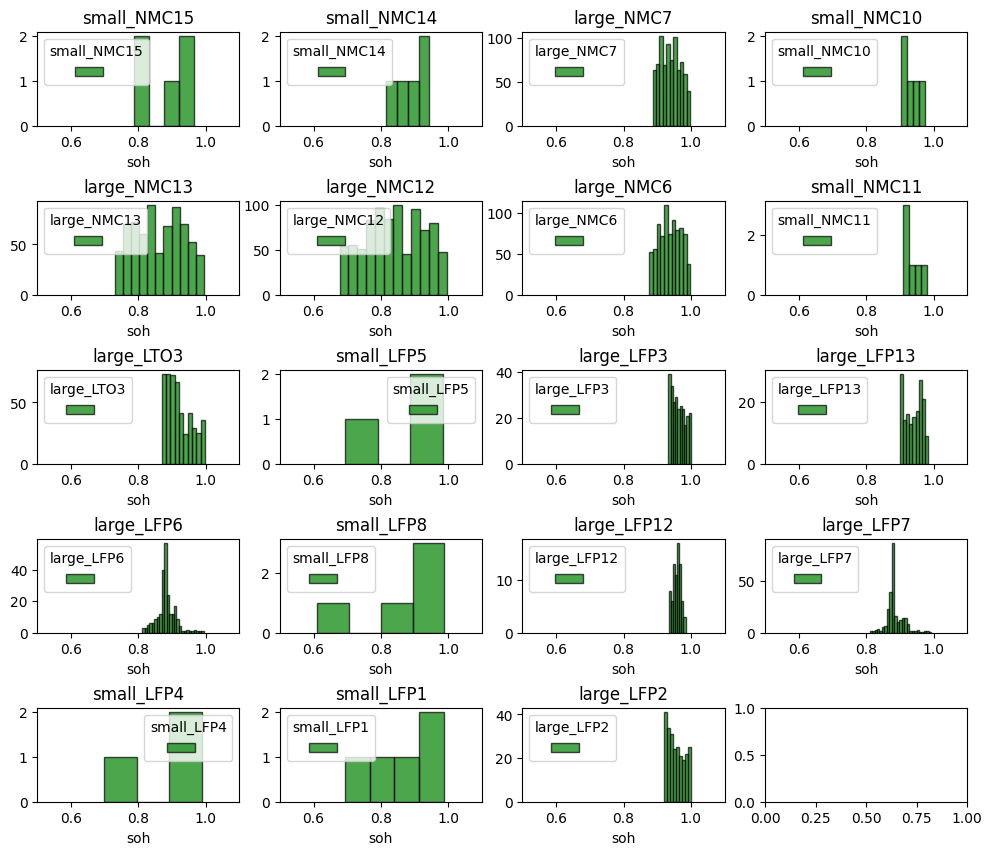

In [16]:
groupBatteriesHist(whitelist_info, SingleBatteryDataset)

### 6.4.2 Large and Small

as can be seen, there are 'large' and 'small' batteries:

In [17]:
whitelist_info.groupby('large_small')['n_cycles'].sum()

large_small
large    5496
small      37
Name: n_cycles, dtype: int64

lets look at them: \
(note that here scale of y-axis (counts) **is not** the same for all graphs)

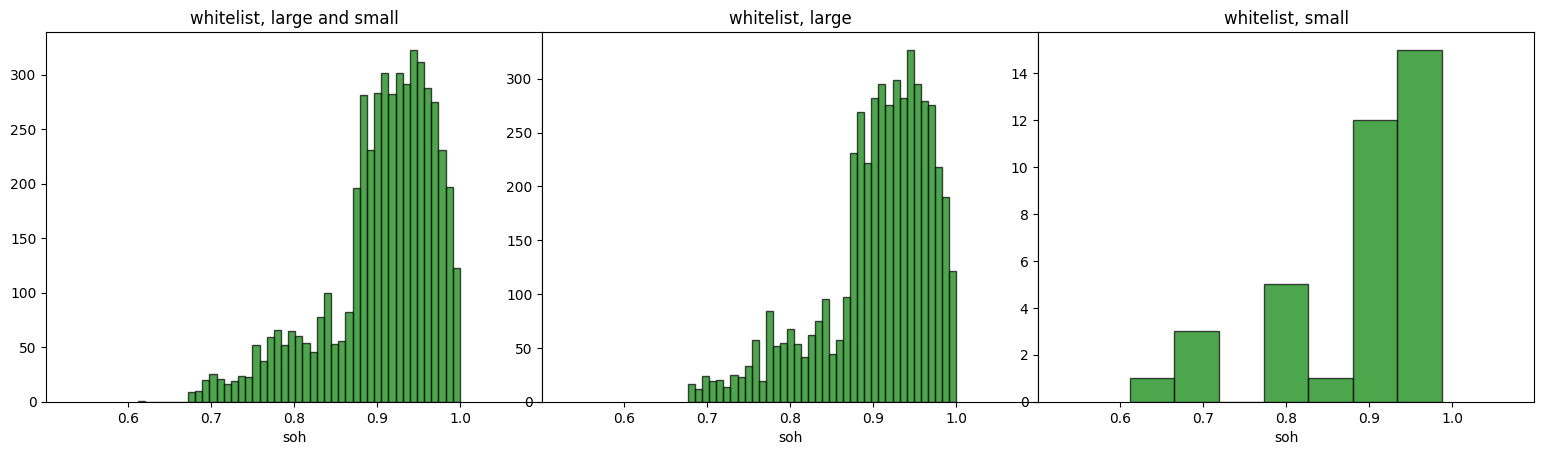

In [18]:
fig, axes = plt.subplots(
    nrows = 1,
    ncols = 3,
    figsize = (6.4*3, 4.8),
    sharex = True,
    #sharey = True,
)
fig.subplots_adjust(wspace = 0)

bagOfCapacitiesHist(
    whitelist_info,
    SingleBatteryDataset,
    title = 'whitelist, large and small',
    ax = axes[0],
)

bagOfCapacitiesHist(
    whitelist_info.query('large_small == \'large\''),
    SingleBatteryDataset,
    title = 'whitelist, large',
    ax = axes[1],
)
bagOfCapacitiesHist(
    whitelist_info.query('large_small == \'small\''),
    SingleBatteryDataset,
    title = 'whitelist, small',
    ax = axes[2],
)

plt.show()

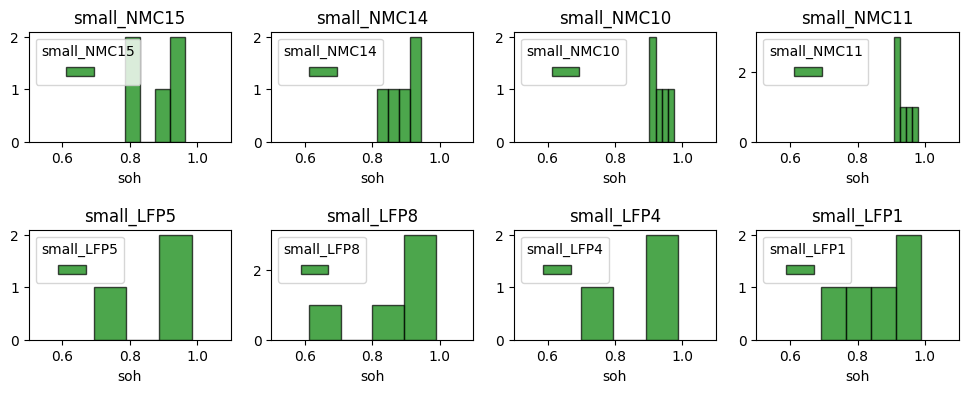

In [19]:
groupBatteriesHist(whitelist_info.query('large_small == \'small\''), SingleBatteryDataset)

it is common to split dataset in such way that train subset consits of higher number of samples, and contribution of small batteries in train subset would be less important, so we'll take them out of train/val/test at all and will use for testing learning pipeline

In [20]:
small_info = whitelist_info.query('large_small == \'small\'')
small_info['ID'].to_list()

['small_NMC15',
 'small_NMC14',
 'small_NMC10',
 'small_NMC11',
 'small_LFP5',
 'small_LFP8',
 'small_LFP4',
 'small_LFP1']

In [21]:
(
    small_info
    .groupby('chem')['n_cycles']
    .agg(
        overall_n_cycles = ('sum'),
        number_of_batteries = ('count'),
    )
)

,overall_n_cycles,number_of_batteries
chem,,
LFP,16,4
NMC,21,4


### 6.4.3 Splitting large batteries

#### n_cycles, chemistries, target distributions, twins

Now, splitting our dataset to train/val/test is reduced to splitting only 'large' batteries, as they are much more important than small ones (though small ones were already send into test subset)

lets have a look on 'large' batteries:

In [22]:
whitelist_large_info = whitelist_info.query('large_small == \'large\'')
print('there is only %s large batteries'%(whitelist_large_info['ID'].count()))

there is only 11 large batteries


there are different types of chemistries:

In [23]:
(
    whitelist_large_info
    .groupby('chem')['n_cycles']
    .agg(
        overall_n_cycles = ('sum'),
        number_of_batteries = ('count'),
    )
)

,overall_n_cycles,number_of_batteries
chem,,
LFP,1432,6
LTO,535,1
NMC,3529,4


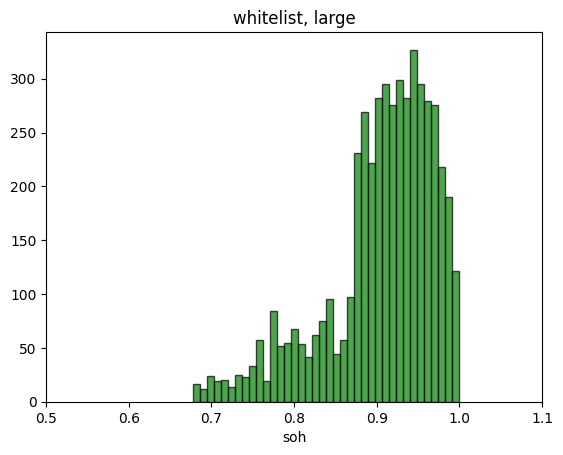

In [24]:
bagOfCapacitiesHist(whitelist_large_info, SingleBatteryDataset, title = 'whitelist, large')

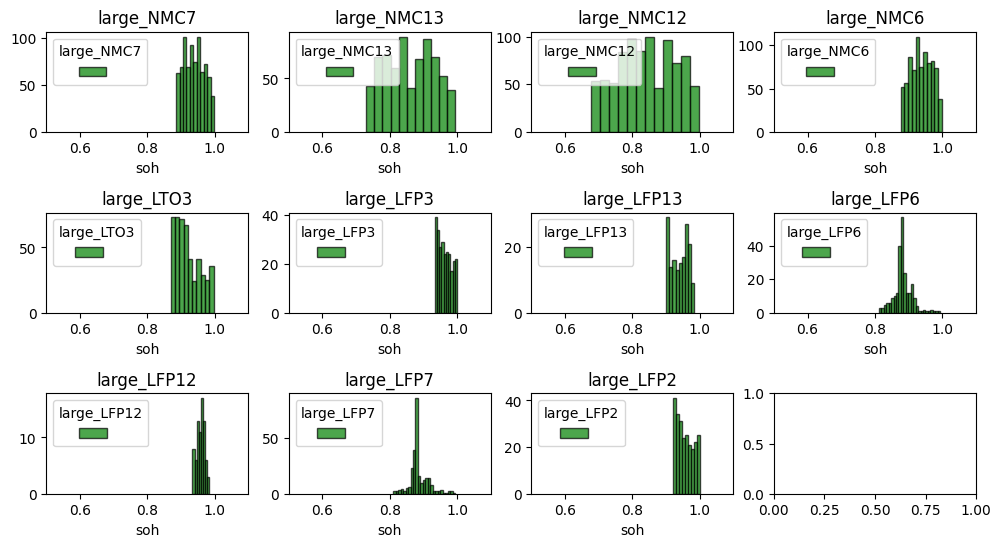

In [25]:
groupBatteriesHist(whitelist_large_info, SingleBatteryDataset)

distributions of targets are different in general, \
but there also are **'twins'**, which have quite similar distributions,  \
so placing them in different subsets can lead to implicit **data leakage**

twins:

*   large_NMC13, large_NMC12
*   large_NMC7, large_NMC6
*   large_LFP3, large_LFP2
*   large_LFP6, large_LFP7

non-twins:

*   large_LTO3
*   large_LFP12
*   large_LFP13










We want all types of samples to be represented in all subsests equally. However, it certainly would not be the case for LTO, because we have only one large sample ('large_LTO3') of it (we actually have small ones, but they were sent to blacklist).   

#### possible splitting combinations (with some restrictions)

lets generate all possible combinations for 5/3/3 splitting with such restrictions:
- if 2 batteries are twins, they cannot be in different subsets
- train subset should have exactly 2 samples of NMC
- each subset should contain more than 1 types (chemistries) of batteries

In [26]:
# @title
import itertools

# Twin groups and single batteries
nmc_twins = [["large_NMC13", "large_NMC12"], ["large_NMC7", "large_NMC6"]]
lfp_twins = [["large_LFP3", "large_LFP2"], ["large_LFP6", "large_LFP7"]]
singles = ["large_LTO3", "large_LFP12", "large_LFP13"]

def get_chem_types(batteries):
    """Return set of battery chemistries in a list"""
    return {b.split('_')[1][:3] for b in batteries}  # Extract first 3 letters (NMC/LFP/LTO)

def is_valid_subset(batteries):
    """Check if subset contains >1 chemistry type"""
    return len(get_chem_types(batteries)) >= 2

def generate_valid_splits():
    valid_splits = []

    # Iterate through NMC twin groups for training
    for nmc_group in nmc_twins:
        # Iterate through LFP twin groups for training
        for lfp_group in lfp_twins:
            remaining_nmc = [g for g in nmc_twins if g != nmc_group][0]
            remaining_lfp = [g for g in lfp_twins if g != lfp_group][0]

            # Split remaining twins between val/test
            for val_twin, test_twin in [(remaining_nmc, remaining_lfp), (remaining_lfp, remaining_nmc)]:
                # Handle single batteries
                for train_single in singles:
                    remaining_singles = [s for s in singles if s != train_single]

                    # Split remaining singles
                    for val_single, test_single in itertools.permutations(remaining_singles, 2):
                        # Compile battery lists
                        split = {
                            "train": sorted([b for pair in [nmc_group, lfp_group] for b in pair] + [train_single]),
                            "val": sorted([b for b in val_twin] + [val_single]),
                            "test": sorted([b for b in test_twin] + [test_single])
                        }

                        # Validate all subsets have multiple chemistries
                        if all(is_valid_subset(split[s]) for s in ["train", "val", "test"]):
                            valid_splits.append(split)

    return valid_splits

# Generate and validate splits
all_splits = generate_valid_splits()

# Print results
print(f"Total valid splits: {len(all_splits)}")
print("\nExample split:")
for subset, batteries in all_splits[0].items():
    print(f"{subset}: {batteries}")
    print(f"Chemistries: {get_chem_types(batteries)}")

Total valid splits: 16

Example split:
train: ['large_LFP12', 'large_LFP2', 'large_LFP3', 'large_NMC12', 'large_NMC13']
Chemistries: {'NMC', 'LFP'}
val: ['large_LFP13', 'large_NMC6', 'large_NMC7']
Chemistries: {'NMC', 'LFP'}
test: ['large_LFP6', 'large_LFP7', 'large_LTO3']
Chemistries: {'LFP', 'LTO'}


we can visualize target distriubions for train/val/test for each splitting:

#### histograms of target distribution for all possible splitting combinations (with restrictions)

----------------------
here is split number 0
----------------------
train: ['large_LFP12', 'large_LFP2', 'large_LFP3', 'large_NMC12', 'large_NMC13']
val: ['large_LFP13', 'large_NMC6', 'large_NMC7']
test: ['large_LFP6', 'large_LFP7', 'large_LTO3']


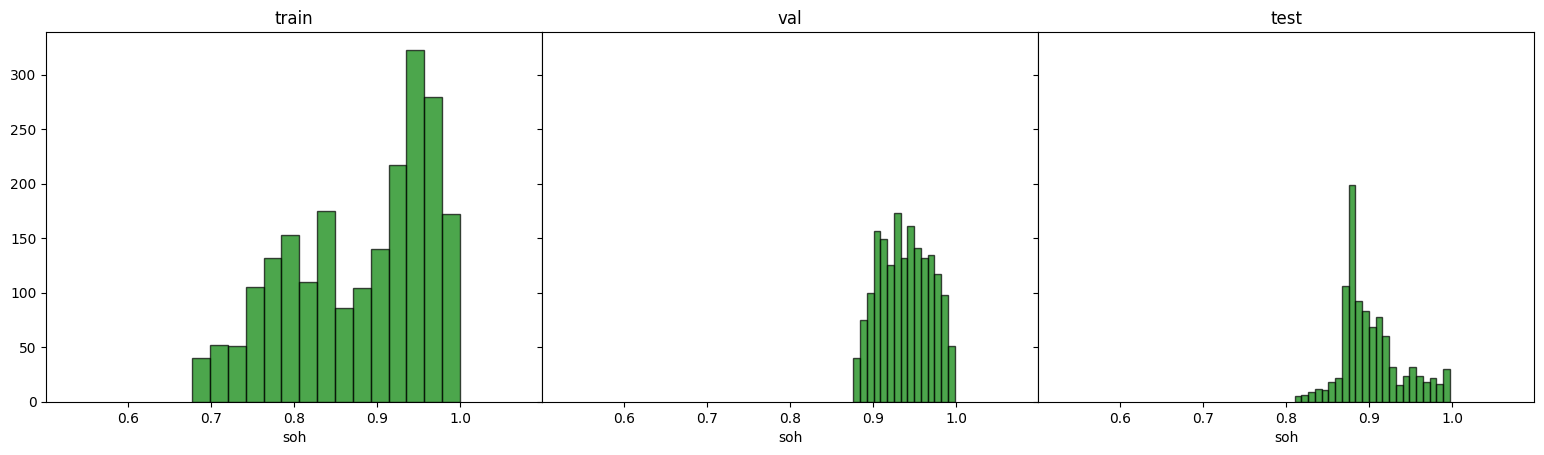

----------------------
here is split number 1
----------------------
train: ['large_LFP13', 'large_LFP2', 'large_LFP3', 'large_NMC12', 'large_NMC13']
val: ['large_LFP12', 'large_NMC6', 'large_NMC7']
test: ['large_LFP6', 'large_LFP7', 'large_LTO3']


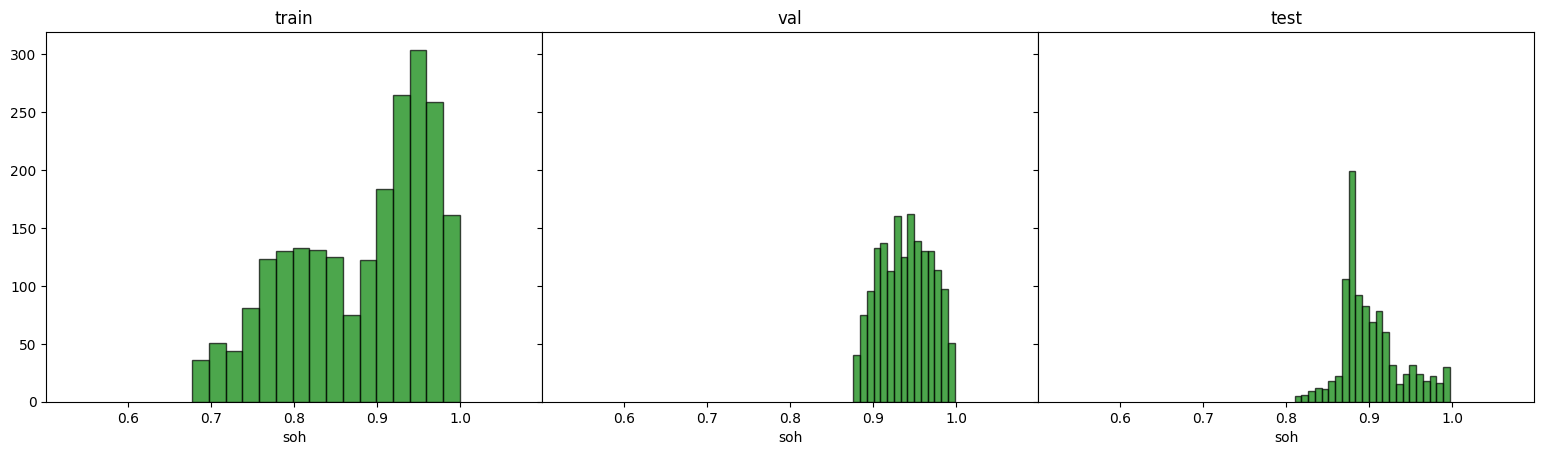

----------------------
here is split number 2
----------------------
train: ['large_LFP12', 'large_LFP2', 'large_LFP3', 'large_NMC12', 'large_NMC13']
val: ['large_LFP6', 'large_LFP7', 'large_LTO3']
test: ['large_LFP13', 'large_NMC6', 'large_NMC7']


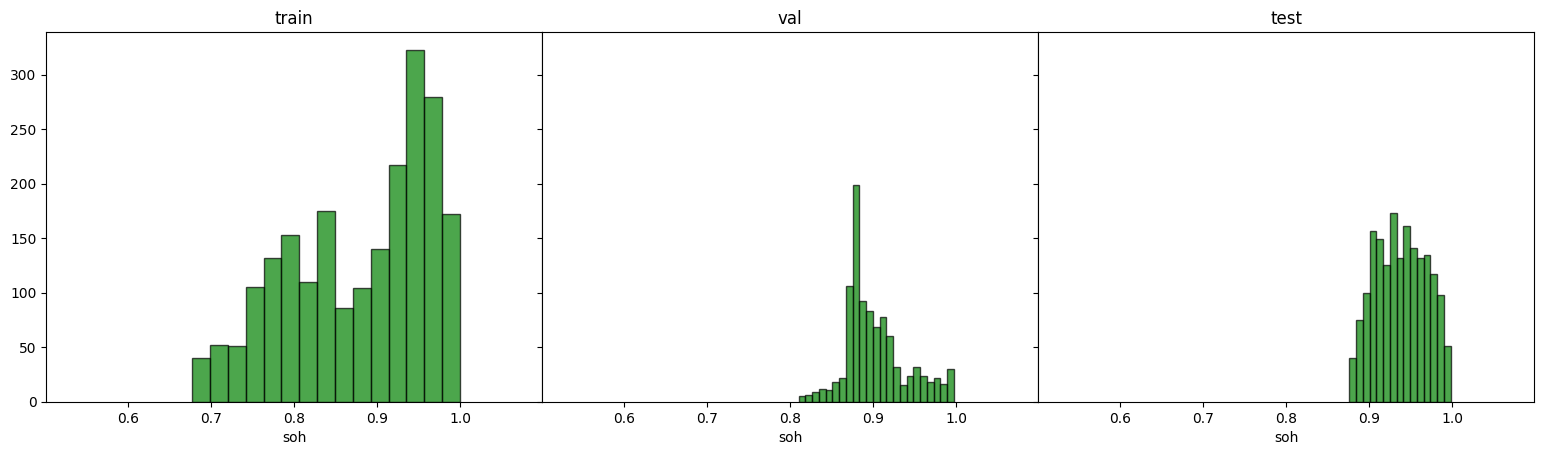

----------------------
here is split number 3
----------------------
train: ['large_LFP13', 'large_LFP2', 'large_LFP3', 'large_NMC12', 'large_NMC13']
val: ['large_LFP6', 'large_LFP7', 'large_LTO3']
test: ['large_LFP12', 'large_NMC6', 'large_NMC7']


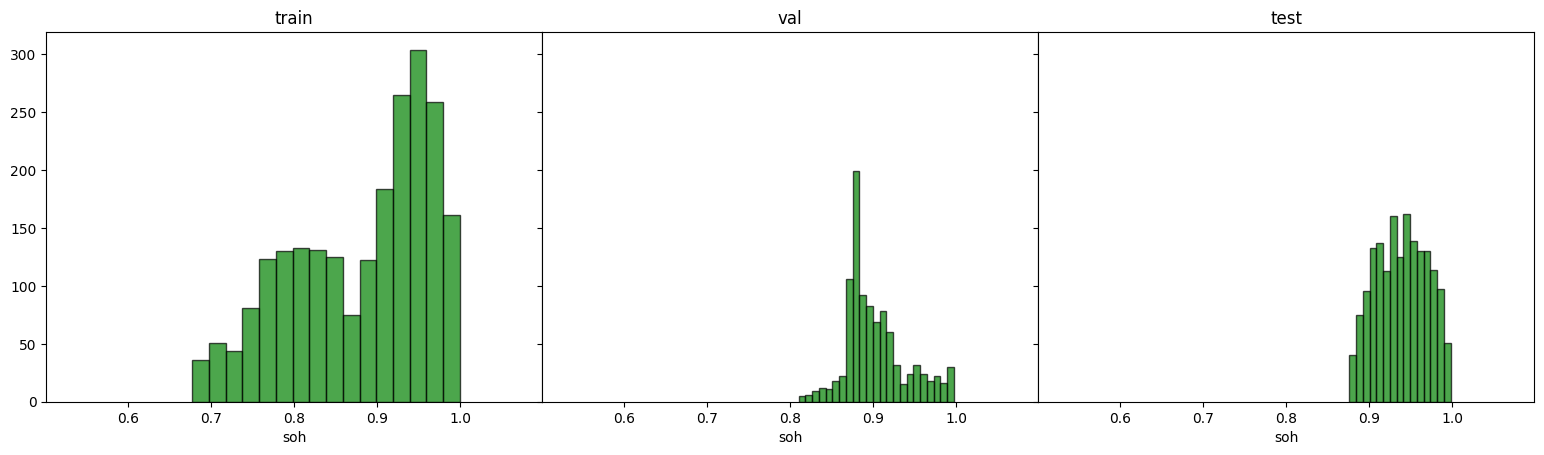

----------------------
here is split number 4
----------------------
train: ['large_LFP12', 'large_LFP6', 'large_LFP7', 'large_NMC12', 'large_NMC13']
val: ['large_LFP13', 'large_NMC6', 'large_NMC7']
test: ['large_LFP2', 'large_LFP3', 'large_LTO3']


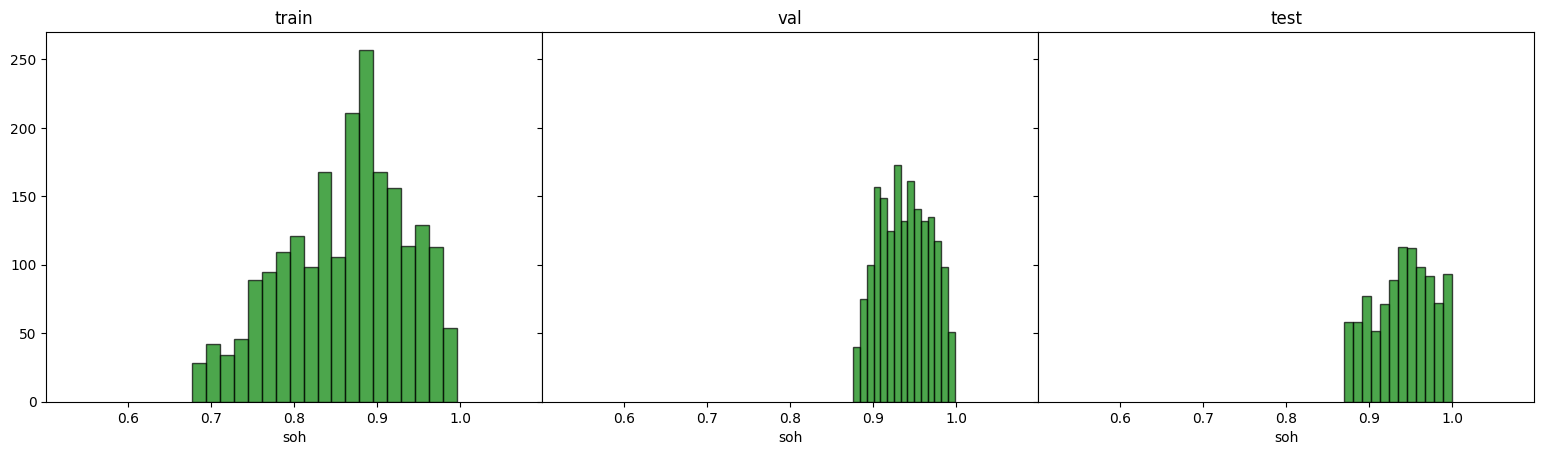

----------------------
here is split number 5
----------------------
train: ['large_LFP13', 'large_LFP6', 'large_LFP7', 'large_NMC12', 'large_NMC13']
val: ['large_LFP12', 'large_NMC6', 'large_NMC7']
test: ['large_LFP2', 'large_LFP3', 'large_LTO3']


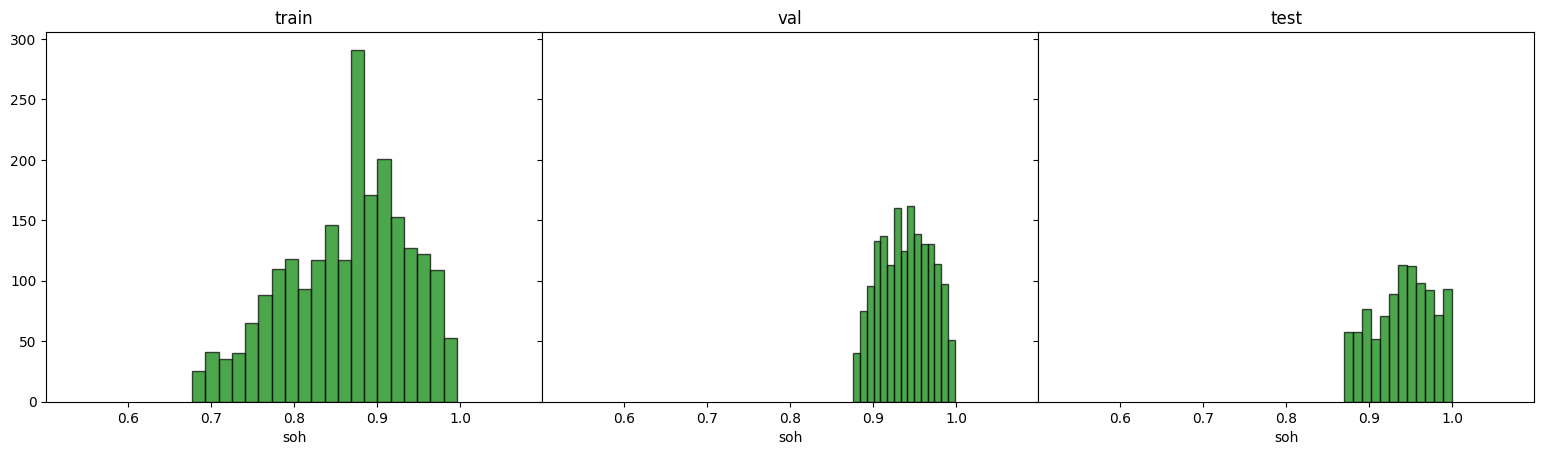

----------------------
here is split number 6
----------------------
train: ['large_LFP12', 'large_LFP6', 'large_LFP7', 'large_NMC12', 'large_NMC13']
val: ['large_LFP2', 'large_LFP3', 'large_LTO3']
test: ['large_LFP13', 'large_NMC6', 'large_NMC7']


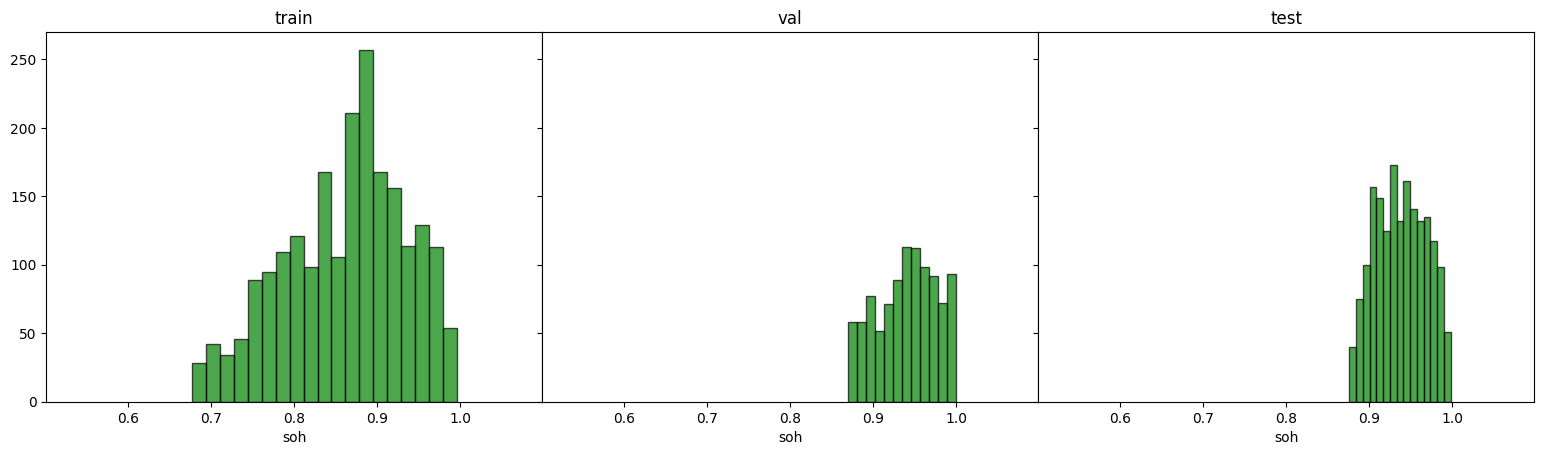

----------------------
here is split number 7
----------------------
train: ['large_LFP13', 'large_LFP6', 'large_LFP7', 'large_NMC12', 'large_NMC13']
val: ['large_LFP2', 'large_LFP3', 'large_LTO3']
test: ['large_LFP12', 'large_NMC6', 'large_NMC7']


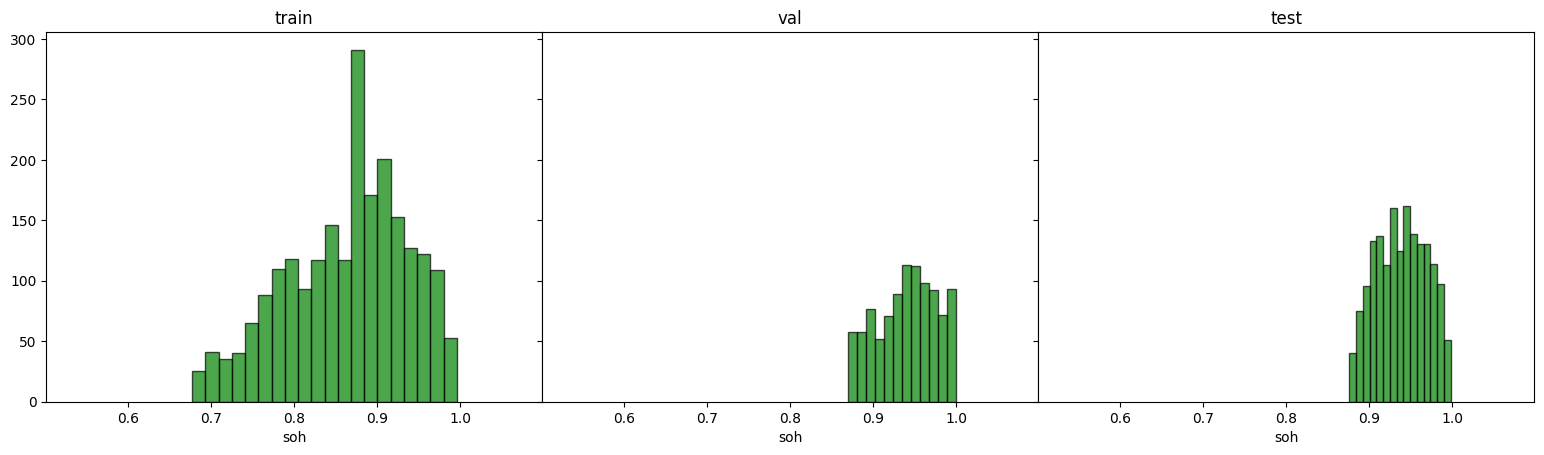

----------------------
here is split number 8
----------------------
train: ['large_LFP12', 'large_LFP2', 'large_LFP3', 'large_NMC6', 'large_NMC7']
val: ['large_LFP13', 'large_NMC12', 'large_NMC13']
test: ['large_LFP6', 'large_LFP7', 'large_LTO3']


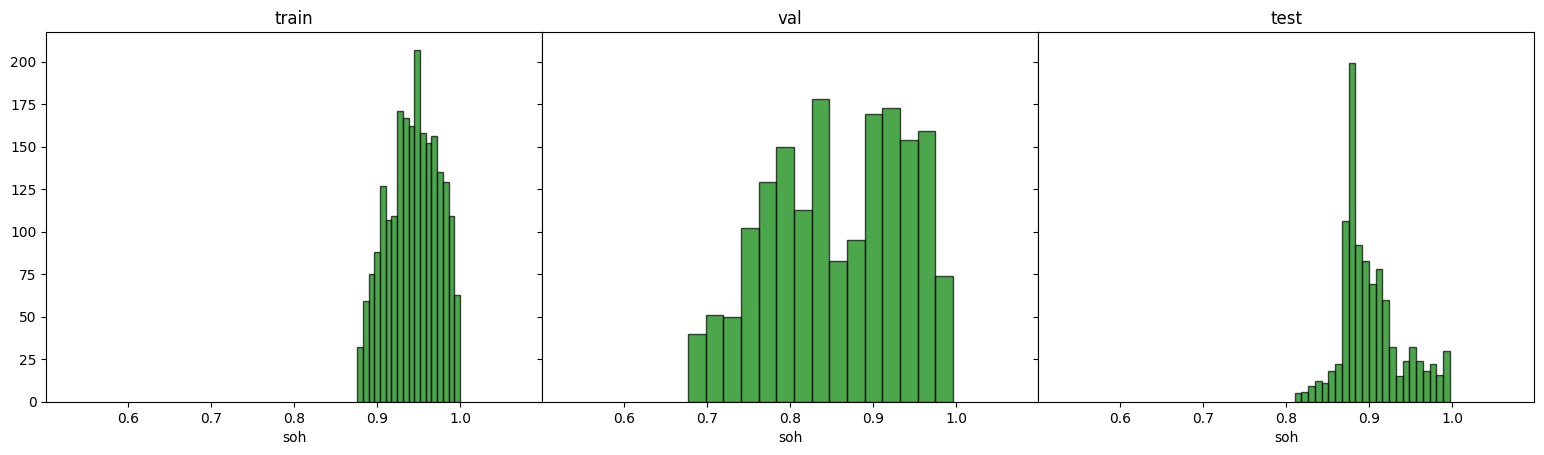

----------------------
here is split number 9
----------------------
train: ['large_LFP13', 'large_LFP2', 'large_LFP3', 'large_NMC6', 'large_NMC7']
val: ['large_LFP12', 'large_NMC12', 'large_NMC13']
test: ['large_LFP6', 'large_LFP7', 'large_LTO3']


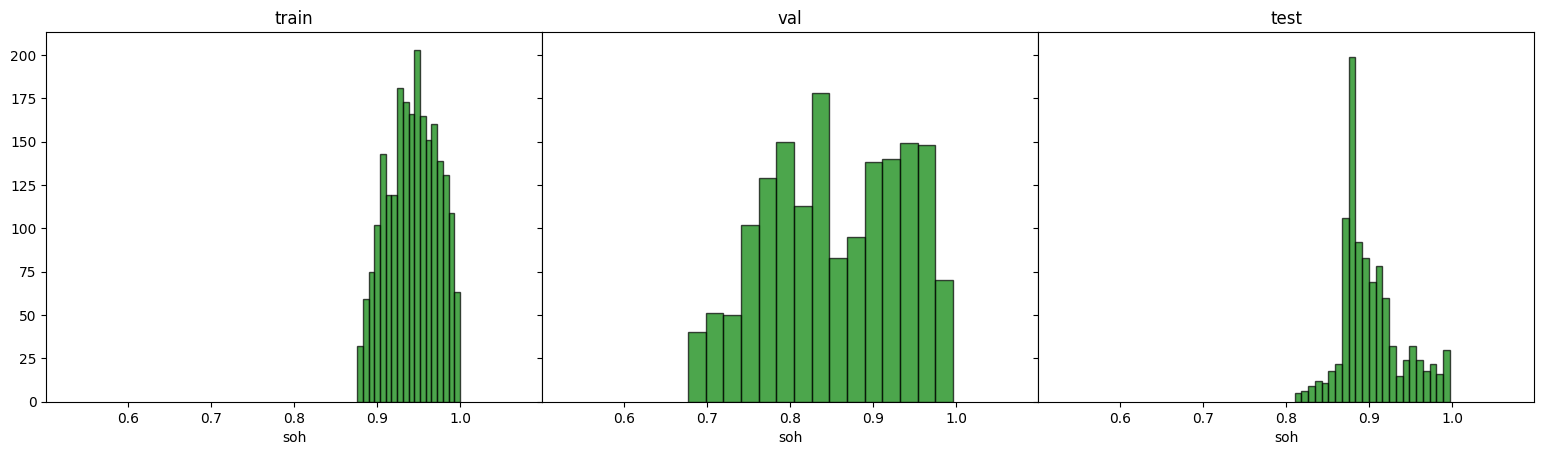

-----------------------
here is split number 10
-----------------------
train: ['large_LFP12', 'large_LFP2', 'large_LFP3', 'large_NMC6', 'large_NMC7']
val: ['large_LFP6', 'large_LFP7', 'large_LTO3']
test: ['large_LFP13', 'large_NMC12', 'large_NMC13']


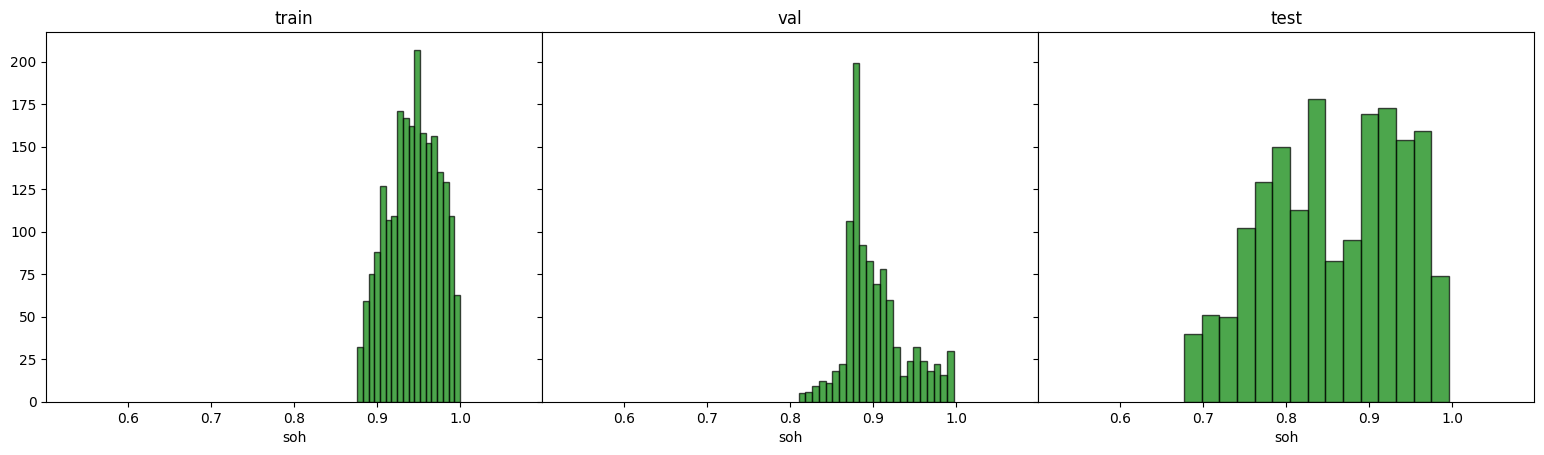

-----------------------
here is split number 11
-----------------------
train: ['large_LFP13', 'large_LFP2', 'large_LFP3', 'large_NMC6', 'large_NMC7']
val: ['large_LFP6', 'large_LFP7', 'large_LTO3']
test: ['large_LFP12', 'large_NMC12', 'large_NMC13']


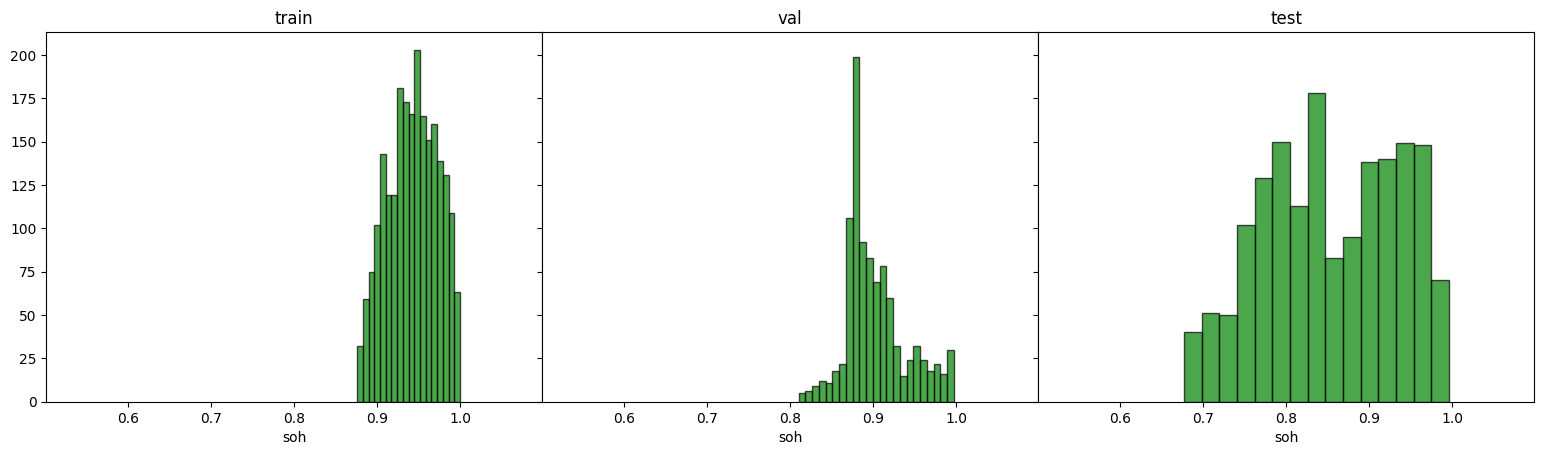

-----------------------
here is split number 12
-----------------------
train: ['large_LFP12', 'large_LFP6', 'large_LFP7', 'large_NMC6', 'large_NMC7']
val: ['large_LFP13', 'large_NMC12', 'large_NMC13']
test: ['large_LFP2', 'large_LFP3', 'large_LTO3']


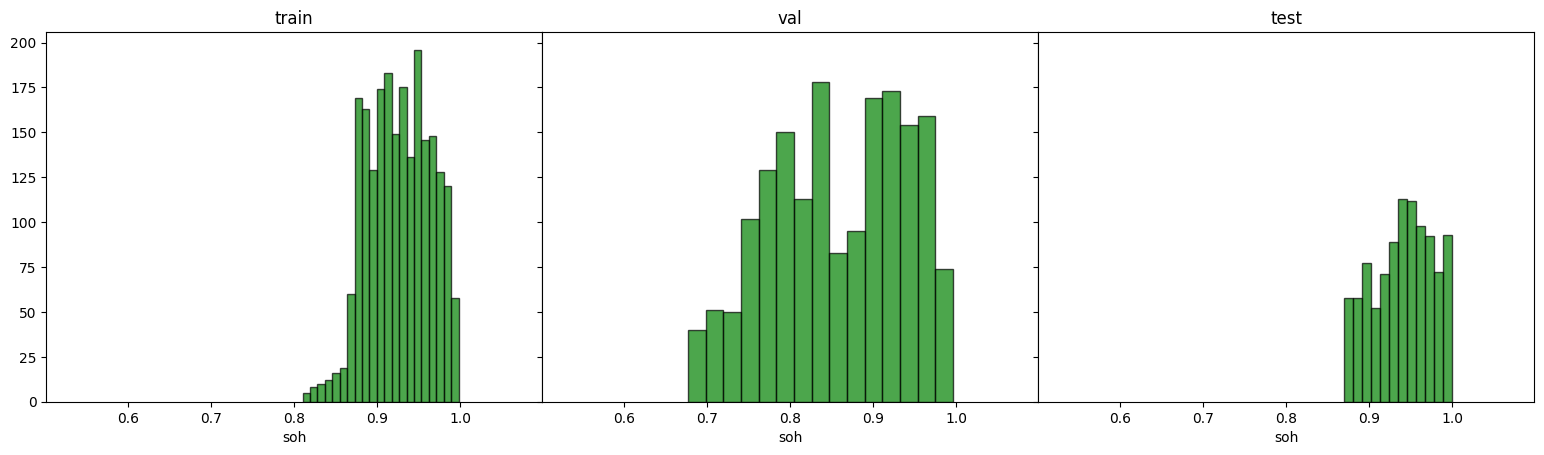

-----------------------
here is split number 13
-----------------------
train: ['large_LFP13', 'large_LFP6', 'large_LFP7', 'large_NMC6', 'large_NMC7']
val: ['large_LFP12', 'large_NMC12', 'large_NMC13']
test: ['large_LFP2', 'large_LFP3', 'large_LTO3']


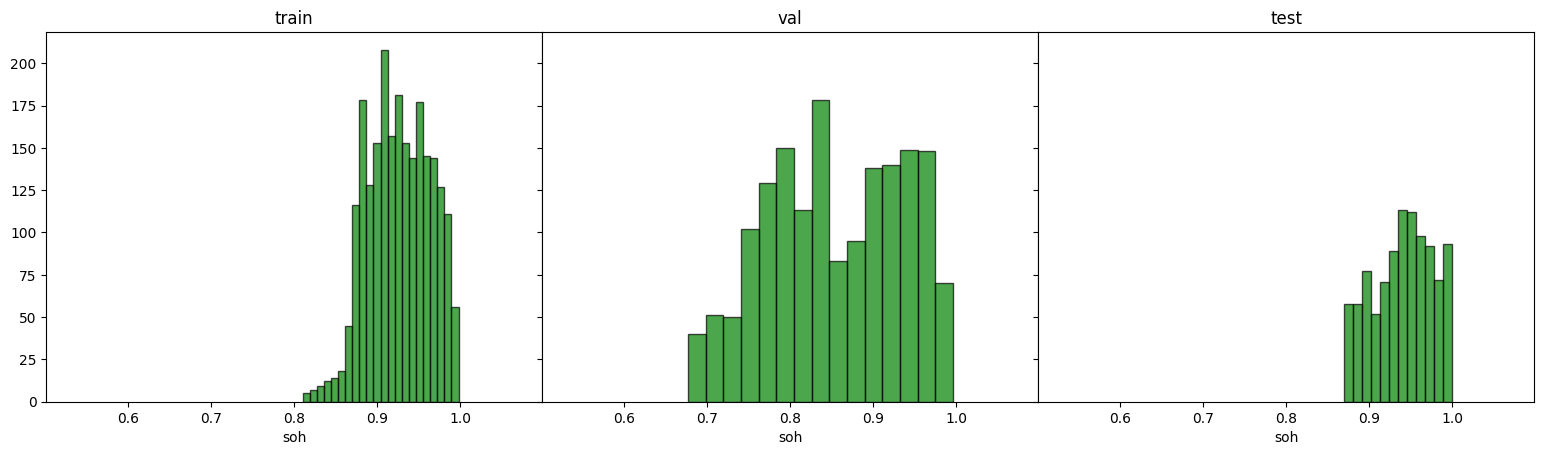

-----------------------
here is split number 14
-----------------------
train: ['large_LFP12', 'large_LFP6', 'large_LFP7', 'large_NMC6', 'large_NMC7']
val: ['large_LFP2', 'large_LFP3', 'large_LTO3']
test: ['large_LFP13', 'large_NMC12', 'large_NMC13']


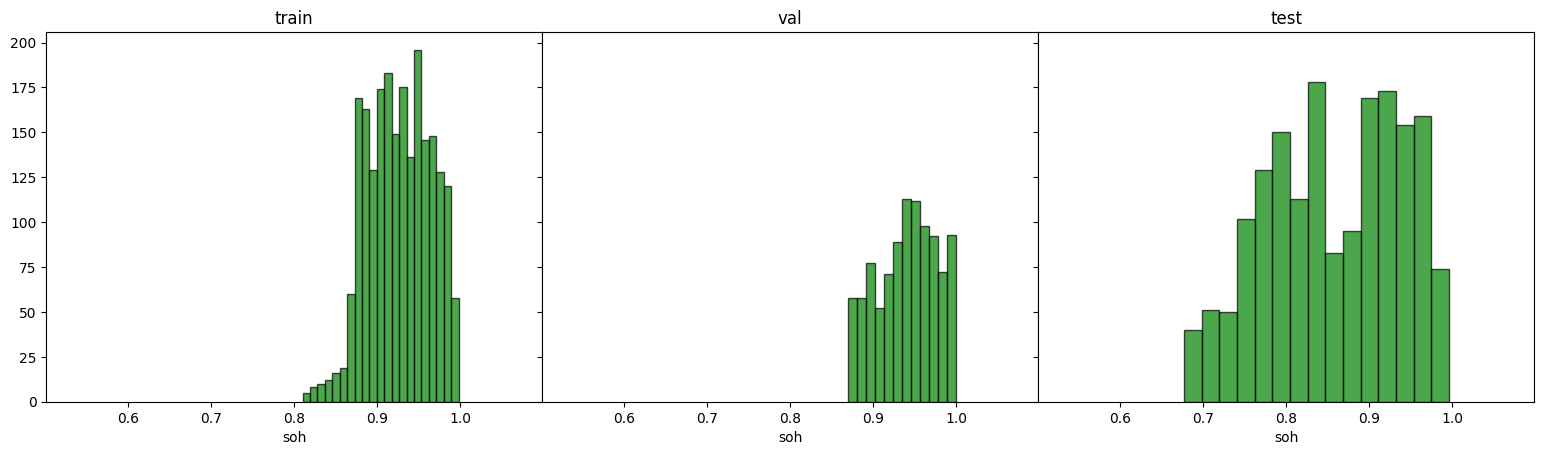

-----------------------
here is split number 15
-----------------------
train: ['large_LFP13', 'large_LFP6', 'large_LFP7', 'large_NMC6', 'large_NMC7']
val: ['large_LFP2', 'large_LFP3', 'large_LTO3']
test: ['large_LFP12', 'large_NMC12', 'large_NMC13']


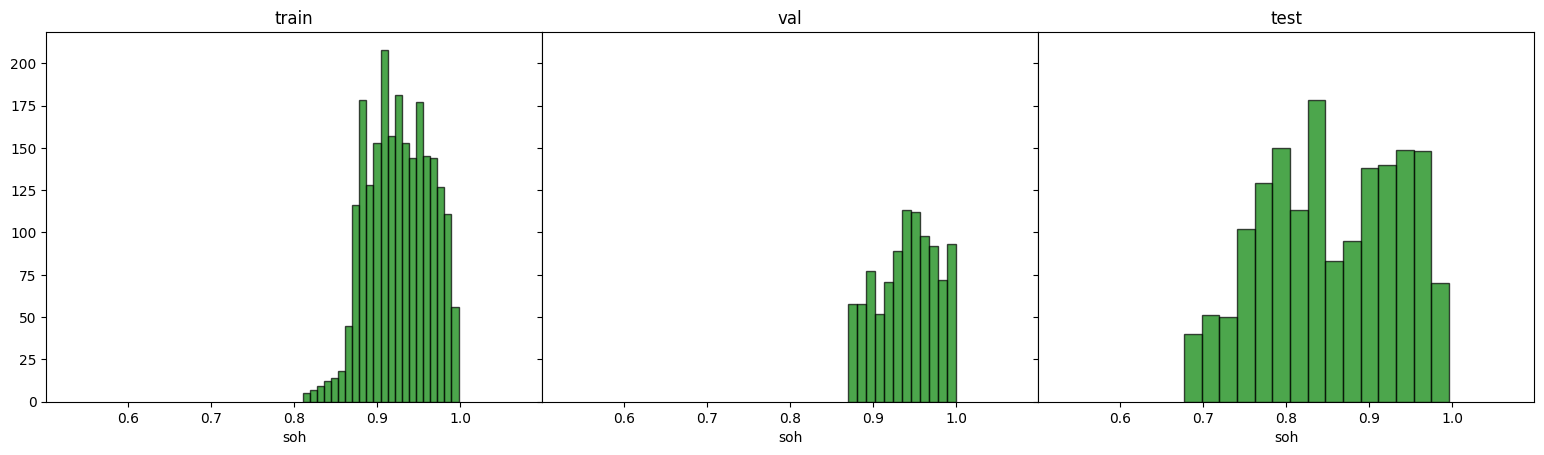

In [27]:
# @title
for i in range(len(all_splits)):
    which_split_str = f'here is split number {i}'
    print('-'*len(which_split_str))
    print(which_split_str)
    print('-'*len(which_split_str))

    fig, axes = plt.subplots(
    nrows = 1,
    ncols = 3,
    figsize = (6.4*3, 4.8),
    sharex = True,
    sharey = True,
    )
    fig.subplots_adjust(wspace = 0)

    for k, (subset, batteries) in enumerate(all_splits[i].items()):
        print(f"{subset}: {batteries}")
        bagOfCapacitiesHist(
            info.query('ID in @batteries'),
            SingleBatteryDataset,
            title = subset,
            ax = axes[k],
        )
    plt.show()

#### KDE visualization of each splitting

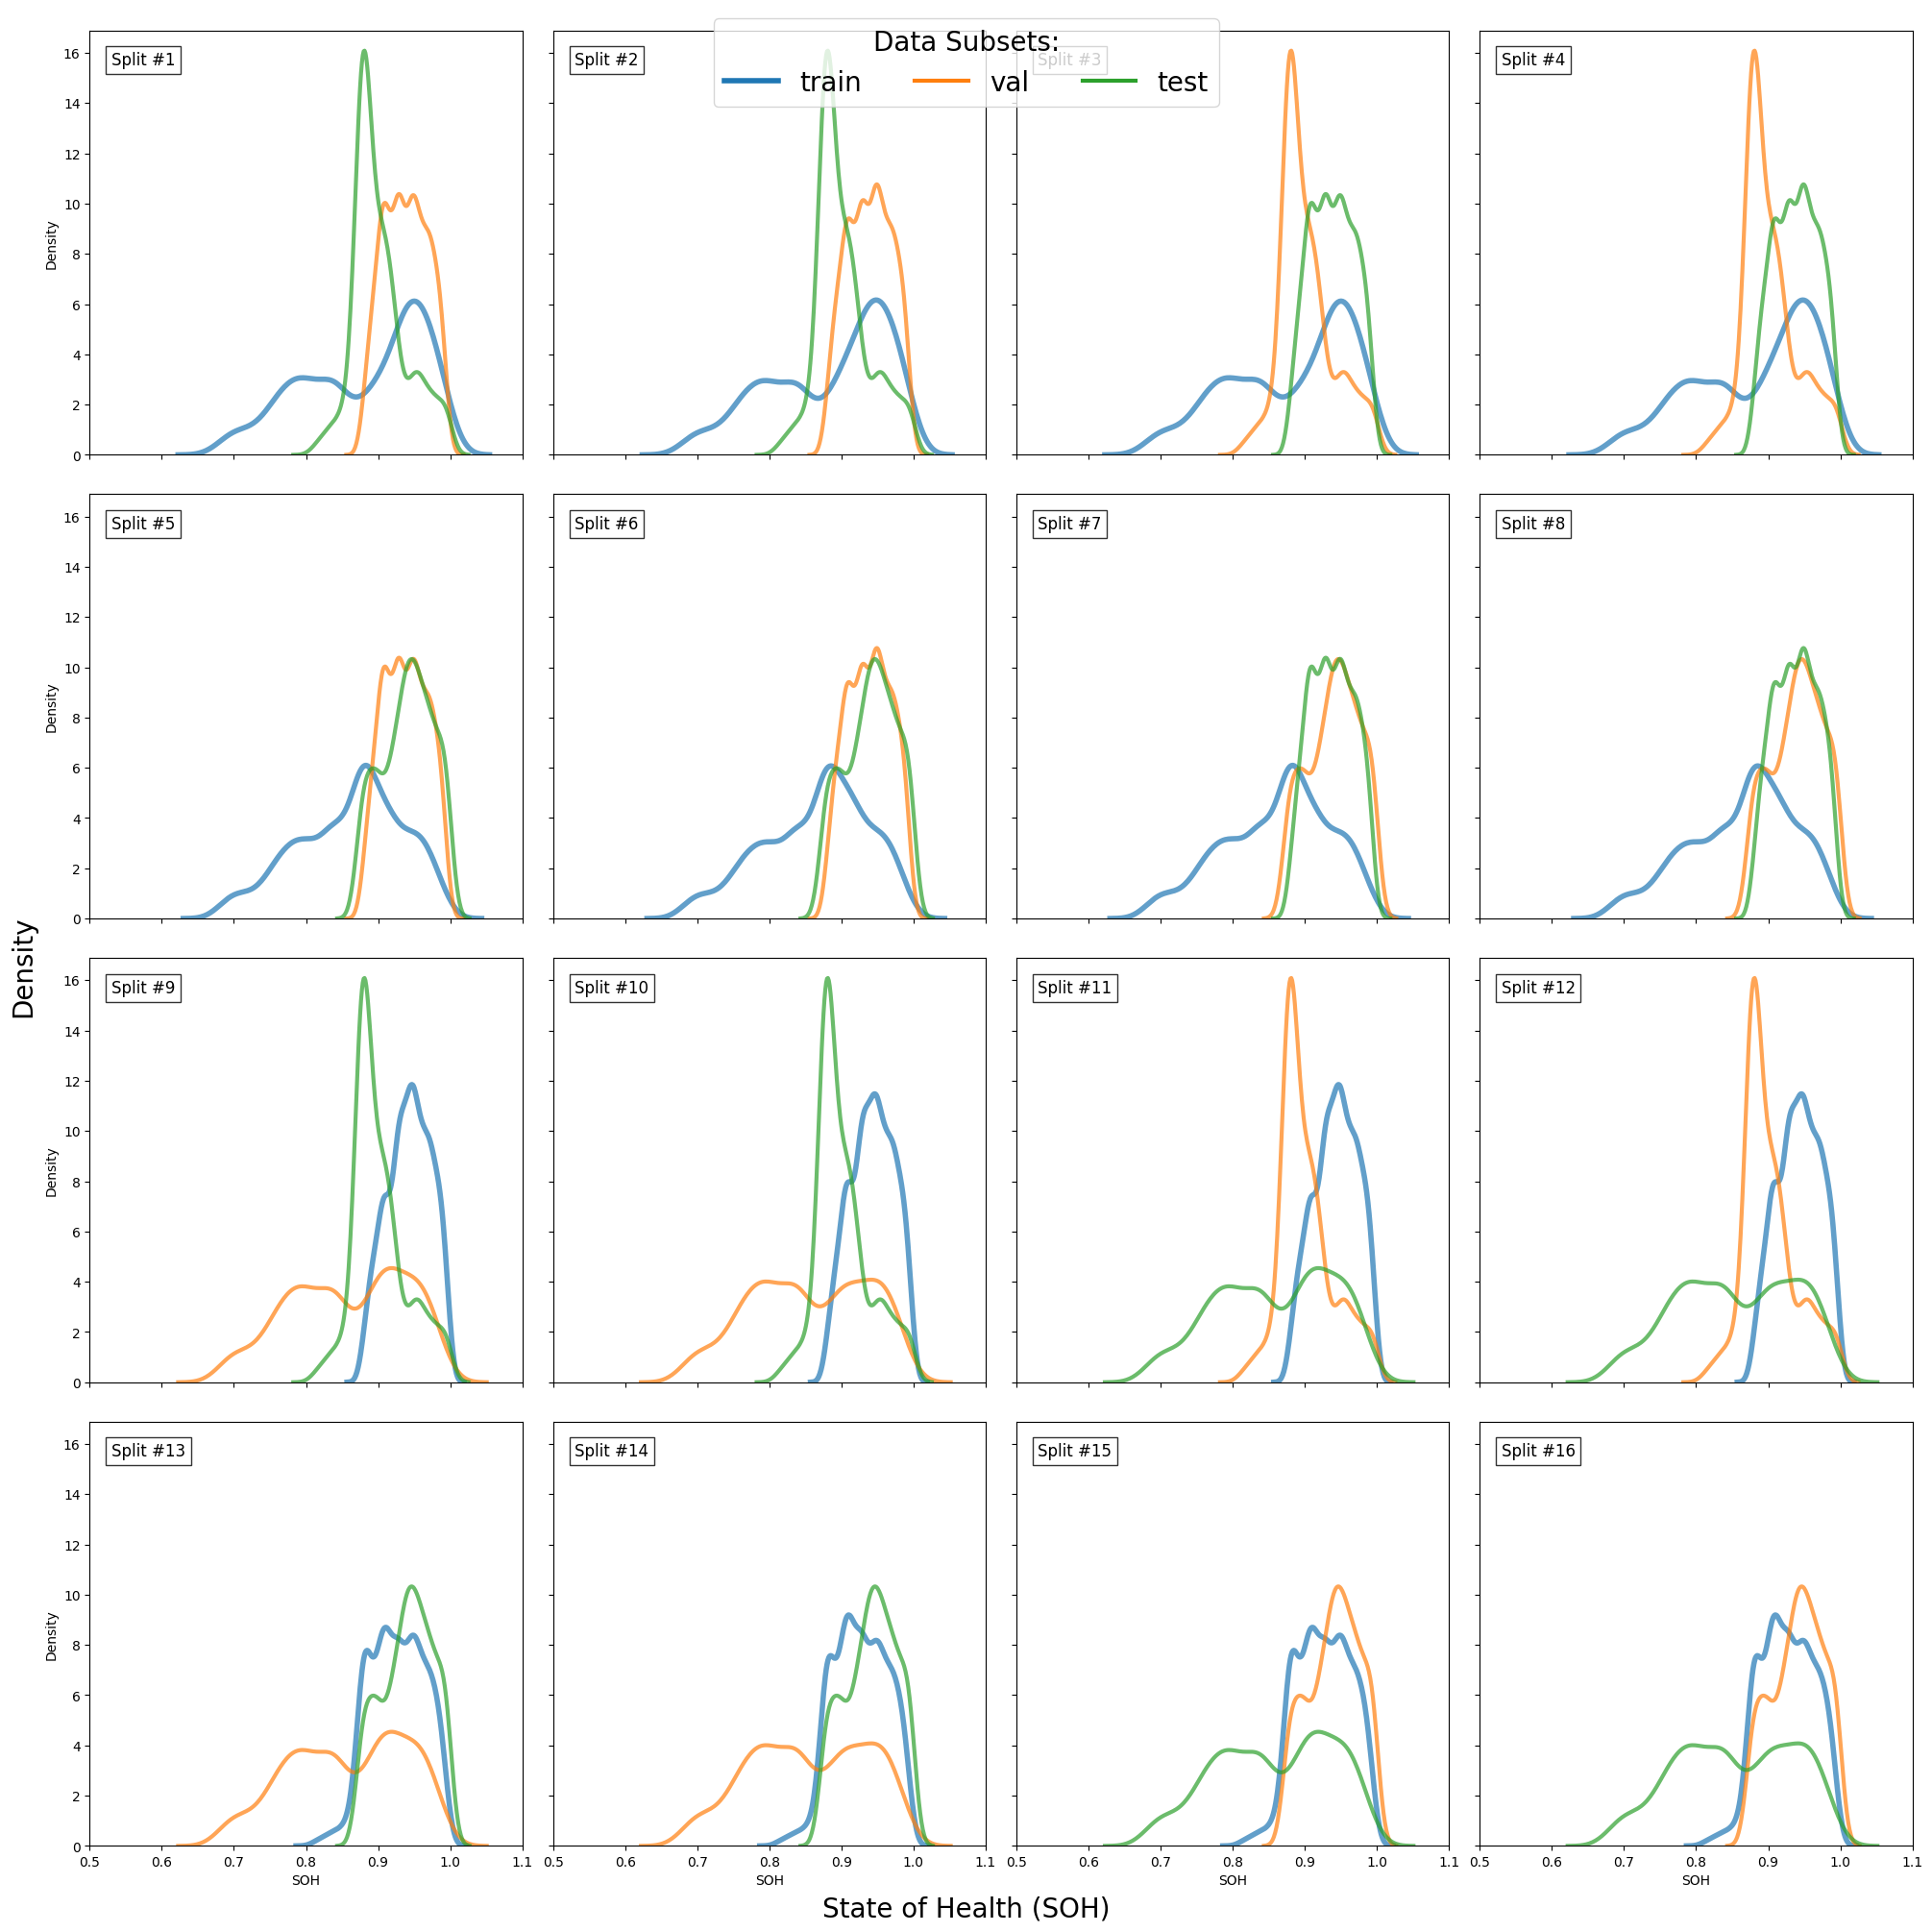

In [28]:
# @title
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def bagOfCapacitiesKDE(info, DataClass, title=' ', ax=None,
                      kde_options={'color': 'green', 'linewidth': 2, 'alpha': 0.7}):
    """KDE version of your capacity distribution plotter"""
    # Extract normalized capacities using your existing DataClass pattern
    all_targets = np.concatenate([
        DataClass(row['battery_path']).data['norm_cap'].to_numpy()
        for _, row in info.iterrows()
    ])

    # Create plot on provided axis or new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.set_title(title)
        sns.kdeplot(all_targets, **kde_options)
        ax.set_xlim(0.5, 1.1)
        ax.set_xlabel('SOH')
        plt.show()
        return fig
    else:
        sns.kdeplot(all_targets, ax=ax, **kde_options)
        ax.set_xlim(0.5, 1.1)
        ax.set_xlabel('SOH')
        ax.set_title(title)
        return ax

# Create composite plot grid with your splits
fig, axs = plt.subplots(4, 4, figsize=(20, 20),
                        sharex=True, sharey=True,
                        constrained_layout=True)
axes = axs.ravel()

# Color scheme and plotting parameters
subset_styles = {
    'train': {'color': 'tab:blue', 'linewidth': 4, 'alpha': 0.7},
    'val': {'color': 'tab:orange', 'linewidth': 3, 'alpha': 0.7},
    'test': {'color': 'tab:green', 'linewidth': 3, 'alpha': 0.7}
}

for split_idx, (split, ax) in enumerate(zip(all_splits, axes)):
    # Plot all subsets on the same axis
    for subset, batteries in split.items():
        # Get battery info for current subset
        subset_info = info[info['ID'].isin(batteries)]

        # Plot KDE using your DataClass pattern
        bagOfCapacitiesKDE(
            subset_info,
            SingleBatteryDataset,  # Replace with your actual DataClass
            ax=ax,
            kde_options={
                'color': subset_styles[subset]['color'],
                'linewidth': subset_styles[subset]['linewidth'],
                'alpha': subset_styles[subset]['alpha'],
                'label': subset.capitalize()
            }
        )

    # Add split annotations

    ax.text(0.05, 0.95, f'Split #{split_idx+1}', transform=ax.transAxes,
            fontsize=12, va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8))

    # Add battery IDs as text table
    '''
    battery_table = '\n'.join([f"{s}: {', '.join(b)}" for s, b in split.items()])
    ax.text(1.02, 0.5, battery_table, transform=ax.transAxes,
            fontsize=6, va='center', ha='left',
            bbox=dict(facecolor='white', alpha=0.7))
    '''

# Configure global labels and legend
fig.supxlabel('State of Health (SOH)', fontsize=20)
fig.supylabel('Density', fontsize=20)
handles = [plt.Line2D([0], [0], color=style['color'], lw=style['linewidth'])
           for style in subset_styles.values()]
fig.legend(handles, subset_styles.keys(),
           loc='upper center', ncol=3,
           bbox_to_anchor=(0.5, 1.0), fontsize=20,
           title='Data Subsets:', title_fontsize=20)

# Set consistent axis limits
plt.setp(axes, xlim=(0.5, 1.1), ylim=(0, None))
plt.show()

as we can see, all splitting are not so good, so maybe, it would be better to choose randomly from one of these splittings

#### random choice from possible splittings (with restrictions)

In [29]:
import random
random.seed(42)
choice_large = random.choice(all_splits)
choice_large

{'train': ['large_LFP13',
  'large_LFP2',
  'large_LFP3',
  'large_NMC12',
  'large_NMC13'],
 'val': ['large_LFP6', 'large_LFP7', 'large_LTO3'],
 'test': ['large_LFP12', 'large_NMC6', 'large_NMC7']}

lets have a look on this splitting:

train: ['large_LFP13', 'large_LFP2', 'large_LFP3', 'large_NMC12', 'large_NMC13']
val: ['large_LFP6', 'large_LFP7', 'large_LTO3']
test: ['large_LFP12', 'large_NMC6', 'large_NMC7']


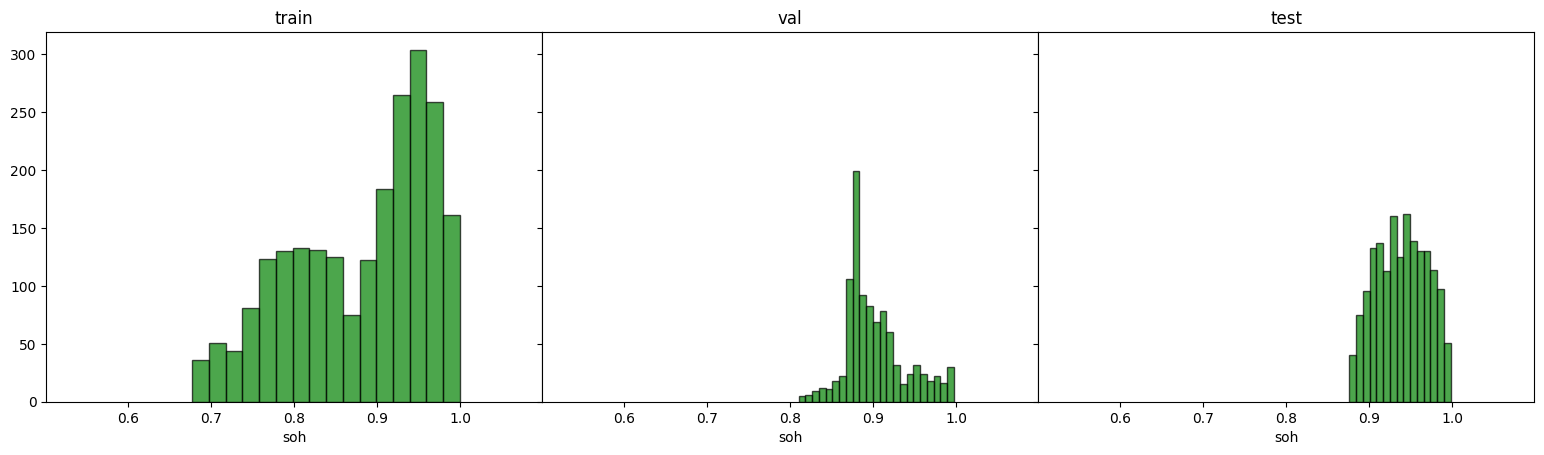

In [30]:
fig, axes = plt.subplots(
nrows = 1,
ncols = 3,
figsize = (6.4*3, 4.8),
sharex = True,
sharey = True,
)
fig.subplots_adjust(wspace = 0)

for k, (subset, batteries) in enumerate(choice_large.items()):
    print(f"{subset}: {batteries}")
    bagOfCapacitiesHist(
        info.query('ID in @batteries'),
        SingleBatteryDataset,
        title = subset,
        ax = axes[k],
    )
plt.show()

## 6.5 finally splitting

lets summarize

- we have blacklist of batteries which would be included in any subset as they have too narrow target distribuyion compared to other samples:

```python
blacklist = [
        'large_LFP10',
        'large_LFP11',
        'large_LTO11',
        'large_LTO12',
        'small_LTO7',
        'small_LTO6',
        'small_LTO4',
        'small_LTO5',
    ]
```
- we decided to put away from dataset all small batteries (which are in whitelist) to perform quick tests of learning pipeline

- then we had to split large batteries in ratio 5/3/3. some restrictions were made (restriction on twins, 2 NMC batteries in train, more than 1 type of chemistry in every subset). we randomly chose splitting from all possible splittings with such restriction. random choice for large batteries is:
```python
choice_large = {'train': ['large_LFP13',
  'large_LFP2',
  'large_LFP3',
  'large_NMC12',
  'large_NMC13'],
 'val': ['large_LFP6', 'large_LFP7', 'large_LTO3'],
 'test': ['large_LFP12', 'large_NMC6', 'large_NMC7']}
 ```


In [31]:
batteries_splitting = choice_large
batteries_splitting

{'train': ['large_LFP13',
  'large_LFP2',
  'large_LFP3',
  'large_NMC12',
  'large_NMC13'],
 'val': ['large_LFP6', 'large_LFP7', 'large_LTO3'],
 'test': ['large_LFP12', 'large_NMC6', 'large_NMC7']}

In [32]:
for subset, batteries in batteries_splitting.items():
    df = whitelist_info.query('ID in @batteries')
    df_aggregated = df.groupby('chem')['n_cycles'].agg(
            overall_n_cycles = ('sum'),
            number_of_batteries = ('count')
        )
    subset_overall_number_cycles = df['n_cycles'].sum()
    print('-'*48)
    print(f'{subset}, overall number of cycles: {subset_overall_number_cycles}')
    print('-'*48)
    display(df_aggregated)

------------------------------------------------
train, overall number of cycles: 2502
------------------------------------------------


,overall_n_cycles,number_of_batteries
chem,,
LFP,763,3
NMC,1739,2


------------------------------------------------
val, overall number of cycles: 1109
------------------------------------------------


,overall_n_cycles,number_of_batteries
chem,,
LFP,574,2
LTO,535,1


------------------------------------------------
test, overall number of cycles: 1885
------------------------------------------------


,overall_n_cycles,number_of_batteries
chem,,
LFP,95,1
NMC,1790,2


train: ['large_LFP13', 'large_LFP2', 'large_LFP3', 'large_NMC12', 'large_NMC13']
val: ['large_LFP6', 'large_LFP7', 'large_LTO3']
test: ['large_LFP12', 'large_NMC6', 'large_NMC7']


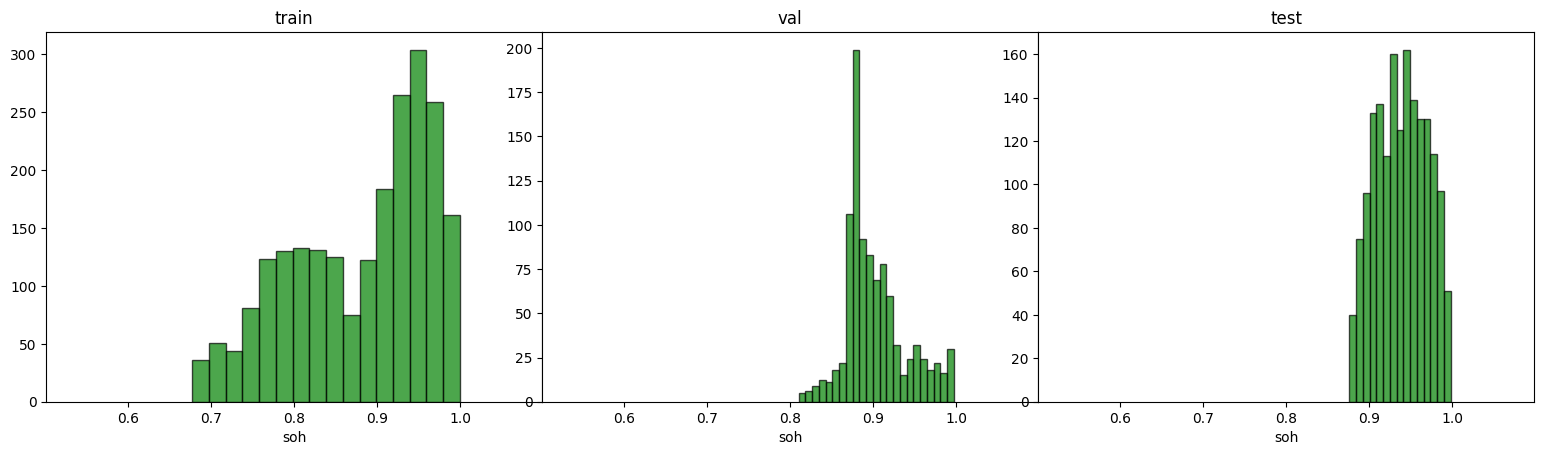

In [33]:
fig, axes = plt.subplots(
nrows = 1,
ncols = 3,
figsize = (6.4*3, 4.8),
sharex = True,
#sharey = True,
)
fig.subplots_adjust(wspace = 0)

for k, (subset, batteries) in enumerate(batteries_splitting.items()):
    print(f"{subset}: {batteries}")
    bagOfCapacitiesHist(
        info.query('ID in @batteries'),
        SingleBatteryDataset,
        title = subset,
        ax = axes[k],
    )
plt.show()

### from earlier google colab notebook run:
```
train: ['large_LFP13', 'large_LFP2', 'large_LFP3', 'large_NMC12', 'large_NMC13']
val: ['large_LFP6', 'large_LFP7', 'large_LTO3']
test: ['large_LFP12', 'large_NMC6', 'large_NMC7']
```